In [1]:
!module load GCC/10.2.0  CUDA/11.1.1  OpenMPI/4.0.5   PyYAML/5.3.1  TensorFlow/2.4.1; #pip install TensorboardX; pip install pandas matplotlib

Lmod has detected the following error:  Your site prevents the
automatic swapping of modules with same name. You must explicitly unload the
loaded version of "CUDA/11.1.1-GCC-10.2.0" before you can load the new one. Use
swap to do this:

   $ module swap CUDA/11.1.1-GCC-10.2.0 CUDA

Alternatively, you can set the environment variable
LMOD_DISABLE_SAME_NAME_AUTOSWAP to "no" to re-enable same name autoswapping.





In [11]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from batchers import batcher
import torch

In [12]:
print(tf.__version__)

2.5.0


In [13]:
DATA_DIR = '/cephyr/NOBACKUP/groups/globalpoverty1/data'


In [5]:
dhs_clusters = pd.read_csv(DATA_DIR + '/dhs_clusters.csv')
dhs_clusters = dhs_clusters.sort_values(['country', 'year']).reset_index(drop=True)

In [6]:
dhs_clusters.head()

,country,year,lat,lon,GID_1,GID_2,households,rural,iwi
0,angola,2006,-12.169283,13.859255,AGO.2,AGO.2.9,20,0,68.096300
1,angola,2006,-12.361700,14.778201,AGO.2,AGO.2.2,19,1,10.609053
2,angola,2006,-10.827451,14.342114,AGO.7,AGO.7.1,25,1,29.973928
3,angola,2006,-9.991311,14.898295,AGO.7,AGO.7.5,1,1,7.704135
4,angola,2006,-11.518893,14.750437,AGO.7,AGO.7.10,24,1,13.371826


In [7]:
tfrecord_files = np.asarray(batcher.create_full_tfrecords_paths(DATA_DIR))

In [8]:
tfrecord_files[:5]

array(['/cephyr/NOBACKUP/groups/globalpoverty1/data/dhs_tfrecords/angola_2006/00000.tfrecord.gz',
       '/cephyr/NOBACKUP/groups/globalpoverty1/data/dhs_tfrecords/angola_2006/00001.tfrecord.gz',
       '/cephyr/NOBACKUP/groups/globalpoverty1/data/dhs_tfrecords/angola_2006/00002.tfrecord.gz',
       '/cephyr/NOBACKUP/groups/globalpoverty1/data/dhs_tfrecords/angola_2006/00003.tfrecord.gz',
       '/cephyr/NOBACKUP/groups/globalpoverty1/data/dhs_tfrecords/angola_2006/00004.tfrecord.gz'],
      dtype='<U109')

In [9]:
dhs_clusters['file'] = tfrecord_files
dhs_clusters.head()

,country,year,lat,lon,GID_1,GID_2,households,rural,iwi,file
0,angola,2006,-12.169283,13.859255,AGO.2,AGO.2.9,20,0,68.096300,/cephyr/NOBACKUP/groups/globalpoverty1/data/dh...
1,angola,2006,-12.361700,14.778201,AGO.2,AGO.2.2,19,1,10.609053,/cephyr/NOBACKUP/groups/globalpoverty1/data/dh...
2,angola,2006,-10.827451,14.342114,AGO.7,AGO.7.1,25,1,29.973928,/cephyr/NOBACKUP/groups/globalpoverty1/data/dh...
3,angola,2006,-9.991311,14.898295,AGO.7,AGO.7.5,1,1,7.704135,/cephyr/NOBACKUP/groups/globalpoverty1/data/dh...
4,angola,2006,-11.518893,14.750437,AGO.7,AGO.7.10,24,1,13.371826,/cephyr/NOBACKUP/groups/globalpoverty1/data/dh...


In [60]:
dhs_clusters.iloc[662]['file']

'/cephyr/NOBACKUP/groups/globalpoverty1/data/dhs_tfrecords/angola_2016/00001.tfrecord.gz'

In [12]:
sample_df = dhs_clusters.nlargest(20, 'iwi')[10:12]
sample_df

,country,year,lat,lon,GID_1,GID_2,households,rural,iwi,file
48761,south_africa,2016,-34.182927,22.150469,ZAF.9,ZAF.9.4,5,0,82.966771,/cephyr/NOBACKUP/groups/globalpoverty1/data/dh...
48754,south_africa,2016,-34.149571,18.858092,ZAF.9,ZAF.9.3,3,0,82.882893,/cephyr/NOBACKUP/groups/globalpoverty1/data/dh...


In [13]:
plot_files = sample_df['file'].values

In [58]:
ds = batcher.get_dataset(plot_files, 0, labeled=False, size_of_window=10,
                         one_year_model=False, n_year_composites=10,
                         normalize=False, max_epochs=1)

In [17]:
ds

<ParallelMapDataset shapes: {model_input: (10, 224, 224, 8), outputs_mask: (10,)}, types: {model_input: tf.float32, outputs_mask: tf.float32}>

In [62]:
NUM_BATCHES = 2
ds = ds.apply(tf.data.experimental.assert_cardinality(NUM_BATCHES))
len(ds)

2

In [63]:
loader = torch.utils.data.DataLoader(ds, batch_size=1)
loader

In [64]:
data = iter(loader)
print(next(data))

TypeError: '_AssertCardinalityDataset' object is not subscriptable

In [16]:
#s_input = next(ds.as_numpy_iterator())
for p, val in ds.as_numpy_iterator():
    print(p, ' : ', val)
print(ds.as_numpy_iterator())
#for ele in ds:
#    print(ele)
#print(s_input[0]['model_input'].shape)

model_input  :  outputs_mask
model_input  :  outputs_mask


In [18]:
def plot_pair(sample_matrix, file_name):
    sample_matrix = sample_matrix.reshape((10*224, 224, 8))
    rgb_image = sample_matrix[:, :, :3][:, :, ::-1]
    dmsp_image = np.dstack([sample_matrix[:8*224, :, -1]] * 3)
    viirs_image = np.dstack([sample_matrix[8*224:, :, -1]] * 3)
    
    rgb_image = np.clip(rgb_image, 0, 0.3) / 0.3
    dmsp_image = (np.clip(dmsp_image, 3, 60) - 3) / (60 - 3)
    viirs_image = np.clip(viirs_image, 0, 60) / 60
    
    nl_image = np.concatenate([dmsp_image, viirs_image], axis=0)
    image = np.concatenate([rgb_image, nl_image], axis=1)
    
    # plt.figure(figsize=[3*6.4, 3*4.8])  # figsize=(224*10, 224*2))
    #subplot(r,c) provide the no. of rows and columns
    # f, axarr = plt.subplots(1, 2)
    # axarr[0].imshow(rgb_image, interpolation='nearest')
    plt.imshow(image, interpolation='nearest', vmin=0, vmax=0.3)
    # axarr[1].imshow(sample_matrix[:, :, -1], interpolation='nearest') 
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    # plt.imsave(fname=file_name, arr=image, format='png')

In [35]:
for d in ds.as_numpy_iterator(): 
    print(type(d['model_input']))
    print(np.shape(d['model_input']))

<class 'numpy.ndarray'>
(10, 224, 224, 8)
<class 'numpy.ndarray'>
(10, 224, 224, 8)


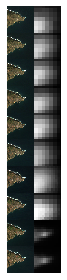

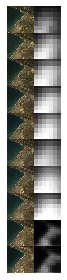

In [102]:
%matplotlib inline
i = 0
for d in ds.as_numpy_iterator():
    country = sample_df.iloc[i]['country']
    df_i = sample_df.iloc[i].name
    plot_pair(d['model_input'], DATA_DIR + f'/images/image_{country}_{df_i}.png')
    i += 1

In [68]:
def plot_image_by_band(img, band_order, nrows, title, rgb=None, colorbar=False):
    '''
    Args
    - img: np.array, shape [H, W, C], type float, normalized
    - band_order: list of str, names of the bands in order
    - nrows: int, desired number of rows in the created figure
    - title: str, or None
    - rgb: one of [None, 'merge', 'add']
        - None: do not create a separate RGB image
        - 'merge': plot the RGB bands as a merged image
        - 'add': plot all bands, but also add a merged RGB image
    - colorbar: bool, whether to show colorbar
    '''
    nbands = img.shape[2]
    rgb_to_naxs = {
        None: nbands,
        'merge': nbands - 2,
        'add': nbands + 1
    }
    nplots = rgb_to_naxs[rgb]
    ncols = int(np.ceil(nplots / float(nrows)))
    fig_w = min(15, 3*ncols)
    fig_h = min(15, 3*nrows)
    fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True,
                            figsize=[fig_w, fig_h], constrained_layout=True)
    if title is not None:
        fig.suptitle(title, y=1.03)

    # scale image to [0,1]: 0 = -3 std, 0.5 = mean, 1 = +3 std
    scaled_img = np.clip(img / 6.0 + 0.5, a_min=0, a_max=1)
    bands = {band_name: scaled_img[:, :, b] for b, band_name in enumerate(band_order)}

    plots = []
    plot_titles = []
    if rgb is not None:
        r, g, b = bands['RED'], bands['GREEN'], bands['BLUE']
        rgb_img = np.stack([r,g,b], axis=2)
        plots.append(rgb_img)
        plot_titles.append('RGB')

    if rgb == 'merge':
        for band_name in band_order:
            if band_name not in ['RED', 'GREEN', 'BLUE']:
                plots.append(bands[band_name])
                plot_titles.append(band_name)
    else:
        plots += [bands[band_name] for band_name in band_order]
        plot_titles += band_order

    for b in range(len(plots)):
        if len(axs.shape) == 1:
            ax = axs[b]
        else:
            ax = axs[b // ncols, b % ncols]
        # set origin='lower' to match lat/lon direction
        im = ax.imshow(plots[b], origin='lower', cmap='viridis', vmin=0, vmax=1)
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title(plot_titles[b])

    if colorbar:
        fig.colorbar(im, orientation='vertical', ax=axs)
    plt.show()

0 BLUE 0.49415 0.0124


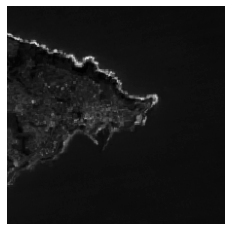

1 GREEN 0.5721 0.01465


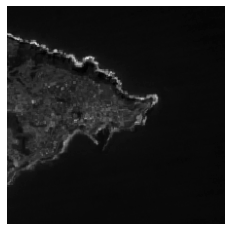

2 RED 0.4659 0.0118


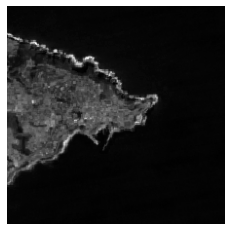

3 SWIR1 0.54 0.00565


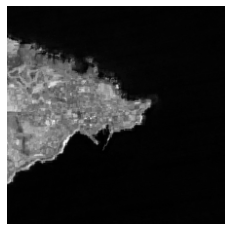

4 SWIR2 0.4809 0.0041


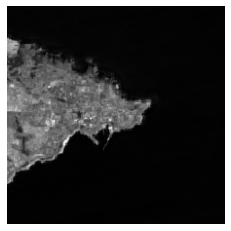

5 TEMP1 300.6 286.7


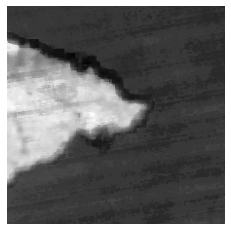

6 NIR 0.5182 0.0074


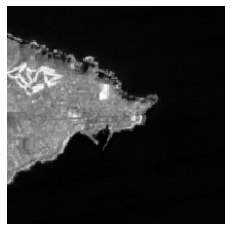

7 NIGHTLIGHTS 33.78 0.43571955


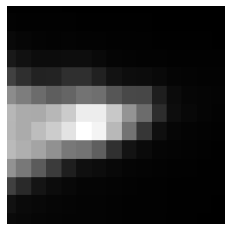

0 BLUE 0.3874 0.016


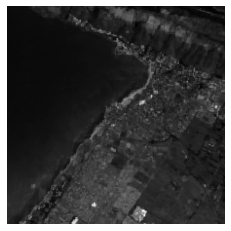

1 GREEN 0.4569 0.022


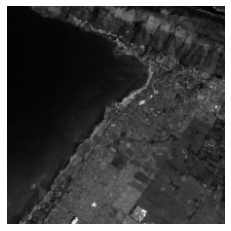

2 RED 0.4849 0.0139


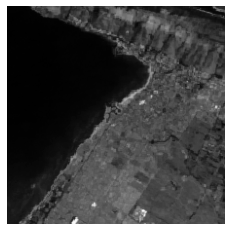

3 SWIR1 0.7653 0.0053


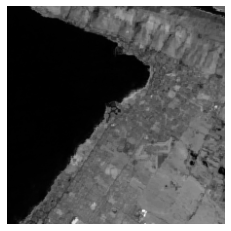

4 SWIR2 0.7584 0.0041


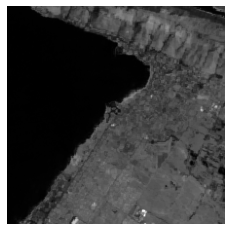

5 TEMP1 303.35 287.5


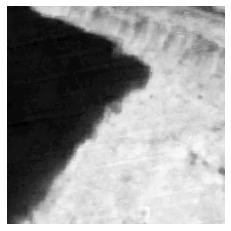

6 NIR 0.52825 0.0089


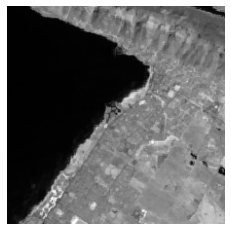

7 NIGHTLIGHTS 35.08 0.6286545


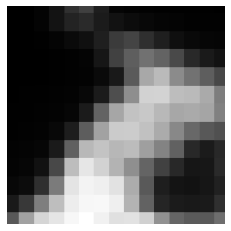

In [69]:
%matplotlib inline
i = 0
BAND_ORDER = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR', 'NIGHTLIGHTS']
for d in ds.as_numpy_iterator():
    img = d['model_input'][-1, :, :]
    
    
    img_normalized = []
    for b_idx, b_name in enumerate(BAND_ORDER):
        band = np.asarray(img[:, :, b_idx], dtype=np.float32)
        # band = np.asarray(feature_map[b_name].float_list.value, dtype=np.float32).reshape(255, 255)
        print(b_idx, b_name, band.max(), band.min())
        plt.imshow(band, cmap='Greys_r')
        plt.axis('off')
        plt.show()
        #b = band_keys_nl[b_idx]
        #band = (band - MEANS[b]) / STD_DEVS[b]
        #img_normalized.append(band)
    #img_normalized = np.stack(img_normalized, axis=2)
    
    #plot_image_by_band(img, BAND_ORDER, 3, 'title', rgb='add')
    #country = sample_df.iloc[i]['country']
    #df_i = sample_df.iloc[i].name
    #plot_pair(d['model_input'], DATA_DIR + f'/images/image_{country}_{df_i}.png')
    #i += 1

## Plot single year image

In [70]:
import json
import pickle
import os

# get all tfrecords
data_dir = DATA_DIR
tfrecord_files = np.asarray(batcher.create_full_tfrecords_paths(data_dir))

# get train, val, test fold
with open(data_dir + '/sorted_dhs_incountry_folds.pkl', 'rb') as pickle_file:
    content = pickle.load(pickle_file)

# get band stats
with open(data_dir + '/band_stats.json') as band_stats_file:
    band_stats = json.load(band_stats_file)

In [71]:
# TODO: loop over all instead?
# select which fold to use
fold = 'A'

train_indices = content[fold]['train']
val_indices = content[fold]['val']

# Sample according to the fraction specified by train_frac and val_frac
train_indices = np.random.choice(train_indices, len(train_indices))
val_indices = np.random.choice(val_indices, len(val_indices))

num_train = len(train_indices)
num_val = len(val_indices)

print('num_train:', num_train)
print('num_val:', num_val)

train_files = tfrecord_files[train_indices]
val_files = tfrecord_files[val_indices]

cache_dir = os.path.join(data_dir, 'cached_datasets', 'hp_tuned_resnet')
train_cache_file = os.path.join(cache_dir, 'train_data')
val_cache_file = os.path.join(cache_dir, 'val_data')

num_train: 34073
num_val: 11358


In [72]:
batch_size = 16
one_year_model = True

ds = batcher.get_dataset(train_files, batch_size, labeled=True, size_of_window=1,
                                one_year_model=one_year_model, n_year_composites=10,
                                normalize=False, band_stats=band_stats[fold], cache_file=None,
                                max_epochs=200)

In [73]:
inputs, labels = next(ds.as_numpy_iterator())

TypeError: Dataset.as_numpy_iterator() does not support datasets containing <class 'tensorflow.python.data.util.structure.NoneTensor'>

In [74]:
print(inputs.shape)

NameError: name 'inputs' is not defined

In [75]:
BAND_ORDER = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR', 'NIGHTLIGHTS']

# iterate over batch
for i in range(inputs.shape[0]):
    img = inputs[i, :, :, :]
    for b_idx, b_name in enumerate(BAND_ORDER):
        band = np.asarray(img[:, :, b_idx], dtype=np.float32)
        # band = np.asarray(feature_map[b_name].float_list.value, dtype=np.float32).reshape(255, 255)
        print(b_idx, b_name, band.max(), band.min())
        plt.imshow(band, cmap='Greys_r')
        plt.axis('off')
        plt.show()

NameError: name 'inputs' is not defined

In [76]:
labels

NameError: name 'labels' is not defined

In [77]:
for entry in ds.as_numpy_iterator():
    print(entry[0])
    
%matplotlib inline
i = 0
BAND_ORDER = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR', 'NIGHTLIGHTS']
for d in ds.as_numpy_iterator():
    img = d['model_input'][-1, :, :]
    
    
    img_normalized = []
    for b_idx, b_name in enumerate(BAND_ORDER):
        band = np.asarray(img[:, :, b_idx], dtype=np.float32)
        # band = np.asarray(feature_map[b_name].float_list.value, dtype=np.float32).reshape(255, 255)
        print(b_idx, b_name, band.max(), band.min())
        plt.imshow(band, cmap='Greys_r')
        plt.axis('off')
        plt.show()
        #b = band_keys_nl[b_idx]
        #band = (band - MEANS[b]) / STD_DEVS[b]
        #img_normalized.append(band)
    #img_normalized = np.stack(img_normalized, axis=2)
    
    #plot_image_by_band(img, BAND_ORDER, 3, 'title', rgb='add')
    #country = sample_df.iloc[i]['country']
    #df_i = sample_df.iloc[i].name
    #plot_pair(d['model_input'], DATA_DIR + f'/images/image_{country}_{df_i}.png')
    #i += 1

TypeError: Dataset.as_numpy_iterator() does not support datasets containing <class 'tensorflow.python.data.util.structure.NoneTensor'>

In [78]:
band_stats['A']

{'means': {'BLUE': 0.06614169065743208,
  'GREEN': 0.09635988259340068,
  'RED': 0.11381173286380034,
  'SWIR1': 0.2403052018705142,
  'SWIR2': 0.169467635861788,
  'TEMP1': 281.2976763110107,
  'NIR': 0.24095368620456603,
  'DMSP': 13.069690484896771,
  'VIIRS': 5.075756473790338},
 'stds': {'BLUE': 0.03512808462999218,
  'GREEN': 0.050729950158437294,
  'RED': 0.07239252056994558,
  'SWIR1': 0.12444550248291769,
  'SWIR2': 0.10850729467914068,
  'TEMP1': 71.28094889057179,
  'NIR': 0.09077465132496389,
  'DMSP': 18.566259343422725,
  'VIIRS': 15.861609457767129}}

In [79]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [80]:
x_train[0].shape

(28, 28)

In [81]:
import scipy.ndimage

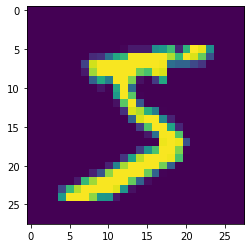

In [82]:
plt.imshow(x_train[0])

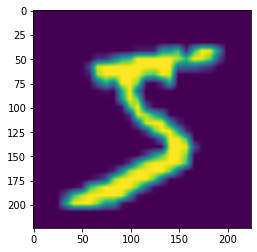

In [83]:
plt.imshow(scipy.ndimage.zoom(x_train[0], zoom = (8,8), order = 1))

In [84]:
scipy.ndimage.zoom(x_train[0], zoom = (8,8), order = 1).shape

(224, 224)

# BENNO TEST

In [66]:
ANGOLA_IMGS = '/cephyr/NOBACKUP/groups/globalpoverty1/data/angola_2006'
dhs_clusters = pd.read_csv(DATA_DIR + '/dhs_clusters.csv')
dhs_clusters = dhs_clusters.sort_values(['country', 'year']).reset_index(drop=True)

In [67]:
!pip install tfrecord

!python3 -m tfrecord.tools.tfrecord2idx '/cephyr/NOBACKUP/groups/globalpoverty1/data' '/cephyr/NOBACKUP/groups/globalpoverty1/JesperBenjamin/Processtf_records/'

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/apps/Alvis/software/Python/3.8.6-GCCcore-10.2.0/bin/python3.8 -m pip install --upgrade pip' command.
/apps/Alvis/software/Python/3.8.6-GCCcore-10.2.0/lib/python3.8/runpy.py:127: RuntimeWarning: 'tfrecord.tools.tfrecord2idx' found in sys.modules after import of package 'tfrecord.tools', but prior to execution of 'tfrecord.tools.tfrecord2idx'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
Traceback (most recent call last):
  File "/apps/Alvis/software/Python/3.8.6-GCCcore-10.2.0/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/apps/Alvis/software/Python/3.8.6-GCCcore-10.2.0/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/cephyr/users/benvin/Alvis/.local/lib/python3.8/site-packages/tfrecord/tools/tfrecord2idx.py", line 51, in <module>
    main()
  F

In [91]:
from tfrecord.torch.dataset import TFRecordDataset
from tfrecord.torch.dataset import MultiTFRecordDataset
import os

In [128]:
tfrecord_folder = "/cephyr/NOBACKUP/groups/globalpoverty1/JesperBenjamin/Processtf_records/zambia_2019/"
from os import walk

files = []
for (dirpath, dirnames, filenames) in walk(tfrecord_folder):
    for file in filenames:
        files.append(file.rsplit('.')[0])
    break

files

00002


['00003',
 '00007',
 '00009',
 '00012',
 '00001',
 '00010',
 '00000',
 '00005',
 '00008',
 '00006',
 '00011',
 '00004',
 '00002']

In [123]:
import sys
import struct

def create_index(tfrecord_file: str, index_file: str) -> None:
    """Create index from the tfrecords file.
    Stores starting location (byte) and length (in bytes) of each
    serialized record.
    Params:
    -------
    tfrecord_file: str
        Path to the TFRecord file.
    index_file: str
        Path where to store the index file.
    """
    infile = open(tfrecord_file, "rb")
    outfile = open(index_file, "w")

    while True:
        current = infile.tell()
        try:
            #print(1)
            byte_len = infile.read(8)
            #print(2)
            if len(byte_len) == 0:
                break
            #print(3)
            infile.read(4)
            #print(4)
            proto_len = struct.unpack("q", byte_len)[0]
            #print(5)
            infile.read(proto_len)
            #print(6)
            infile.read(4)
            #print(7)
            outfile.write(str(current) + " " + str(infile.tell() - current) + "\n")
            #print(8)
        except:
            print("No more samples to parse in this TFRecord / Failed to parse TFRecord.")
            break
    infile.close()
    outfile.close()

In [149]:
infile = open(tfrecord_path, "rb")
infile


<_io.BufferedReader name='/cephyr/NOBACKUP/groups/globalpoverty1/JesperBenjamin/Processtf_records/zambia_2019/00002.tfrecord.gz'>

In [146]:
# Create index files for https://github.com/vahidk/tfrecord

tfrecord_folder = "/cephyr/NOBACKUP/groups/globalpoverty1/JesperBenjamin/Processtf_records/zambia_2019/"
index_folder = "/cephyr/NOBACKUP/groups/globalpoverty1/JesperBenjamin/Processtf_records/zambia_index/"
for file in files:
    tfrecord_path = os.path.join(tfrecord_folder, file + ".tfrecord.gz")
    index_path = os.path.join(index_folder, file + ".index")
    #print(tfrecord_path)
    #print(index_path)
    
    create_index(tfrecord_path, index_path) 
    
    
    

No more samples to parse in this TFRecord / Failed to parse TFRecord.
No more samples to parse in this TFRecord / Failed to parse TFRecord.
No more samples to parse in this TFRecord / Failed to parse TFRecord.
No more samples to parse in this TFRecord / Failed to parse TFRecord.
No more samples to parse in this TFRecord / Failed to parse TFRecord.
No more samples to parse in this TFRecord / Failed to parse TFRecord.
No more samples to parse in this TFRecord / Failed to parse TFRecord.
No more samples to parse in this TFRecord / Failed to parse TFRecord.
No more samples to parse in this TFRecord / Failed to parse TFRecord.
No more samples to parse in this TFRecord / Failed to parse TFRecord.
No more samples to parse in this TFRecord / Failed to parse TFRecord.
No more samples to parse in this TFRecord / Failed to parse TFRecord.
No more samples to parse in this TFRecord / Failed to parse TFRecord.


In [ ]:
#python3 -m tfrecord.tools.tfrecord2idx <tfrecord path> <index path>

In [144]:
tfrecord_path = "/cephyr/NOBACKUP/groups/globalpoverty1/JesperBenjamin/Processtf_records/zambia_2019/{}.tfrecord.gz"
index_path = "/cephyr/NOBACKUP/groups/globalpoverty1/JesperBenjamin/Processtf_records/zambia_index/{}.index"

p_file = 1/len(files)
splits = {}
for img in files:
    splits[img] = p_file
    

bands = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR', 'NIGHTLIGHTS']
scalar_float_keys = ['lat', 'lon', 'year', 'iwi']
keys_to_features = {}
for band in bands:
    keys_to_features[band] = "float"
for key in scalar_float_keys:
    keys_to_features[key] = "float"
dataset = MultiTFRecordDataset(tfrecord_path, index_path, splits, keys_to_features)
loader = torch.utils.data.DataLoader(dataset, batch_size=1)

data = next(iter(loader))
#print(data)
loader

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [141]:
for i, (images) in enumerate(loader):
    print(i)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [150]:
for example in tf.python_io.tf_record_iterator("/cephyr/NOBACKUP/groups/globalpoverty1/JesperBenjamin/Processtf_records/zambia_2019/00000.tfrecord.gz"):
    print(tf.train.Example.FromString(example))

AttributeError: module 'tensorflow' has no attribute 'python_io'

## Mackan print

In [28]:
import glob

directory = '/cephyr/NOBACKUP/groups/globalpoverty1/data/dhs_tfrecords/zambia_2019/*'
tfrecord_files = glob.glob(directory)

dataset = tf.data.TFRecordDataset(
    filenames=tfrecord_files,
    compression_type='GZIP')

# Config image parse from tfrecord
bands = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR', 'NIGHTLIGHTS']
n_temporal_frames = 10
keys_to_features = {}
for band in bands:
    keys_to_features[band] = tf.io.FixedLenFeature(shape=[224 ** 2 * n_temporal_frames], dtype=tf.float32)
scalar_float_keys = ['lat', 'lon', 'year', 'iwi']
for key in scalar_float_keys:
    keys_to_features[key] = tf.io.FixedLenFeature(shape=[], dtype=tf.float32)

# Parse and print all 13 samples
for i, example_proto in enumerate(dataset):
    ex = tf.io.parse_single_example(example_proto, features=keys_to_features)

    print(f'\nLocation nr. {i}')

    # Reshape to (10, 224, 224)
    for band in bands:
        ex[band] = tf.reshape(ex[band], (n_temporal_frames, 224, 224))

    # Print the value for all scalar_float_keys, but only the mean/shape for the bands
    for key in ex.keys():
        if key in bands:
            band_frames = ex[key].numpy()
            print(f'{key}: mean={band_frames.mean():.3f}, shape={band_frames.shape}')
        else:
            # key in scalar_float_keys
            print(f'{key}: {ex[key].numpy()}')
    print('')


Location nr. 0
BLUE: mean=0.067, shape=(10, 224, 224)
GREEN: mean=0.099, shape=(10, 224, 224)
NIGHTLIGHTS: mean=19.349, shape=(10, 224, 224)
NIR: mean=0.216, shape=(10, 224, 224)
RED: mean=0.124, shape=(10, 224, 224)
SWIR1: mean=0.264, shape=(10, 224, 224)
SWIR2: mean=0.204, shape=(10, 224, 224)
TEMP1: mean=299.543, shape=(10, 224, 224)
iwi: 29.487977981567383
lat: -14.420943260192871
lon: 28.417299270629883
year: 2019.0


Location nr. 1
BLUE: mean=0.054, shape=(10, 224, 224)
GREEN: mean=0.083, shape=(10, 224, 224)
NIGHTLIGHTS: mean=3.070, shape=(10, 224, 224)
NIR: mean=0.214, shape=(10, 224, 224)
RED: mean=0.110, shape=(10, 224, 224)
SWIR1: mean=0.264, shape=(10, 224, 224)
SWIR2: mean=0.194, shape=(10, 224, 224)
TEMP1: mean=299.979, shape=(10, 224, 224)
iwi: 19.795644760131836
lat: -16.254650115966797
lon: 26.549083709716797
year: 2019.0


Location nr. 2
BLUE: mean=0.070, shape=(10, 224, 224)
GREEN: mean=0.100, shape=(10, 224, 224)
NIGHTLIGHTS: mean=11.993, shape=(10, 224, 224)
NIR: 

In [10]:
import rasterio as rio
from rasterio.plot import show
import torch
%matplotlib inline

mackan_tif = "/cephyr/NOBACKUP/groups/globalpoverty1/data/dhs_tifs/chad_2015/00000.tif"
img_path = "/cephyr/NOBACKUP/groups/globalpoverty1/Kakooei/DatasetAfricaPoverty/TenYears/Geo0/0000012768-0000011872.tif"
img_src = rio.open(mackan_tif)
img_numpy = img_src.read()
img_tensor = torch.from_numpy(img_numpy)

show(img_src.read([3,2,1]), adjust=True)

RasterioIOError: '/cephyr/NOBACKUP/groups/globalpoverty1/data/dhs_tifs/chad_2015/00000.tif' not recognized as a supported file format.